# Structural Estimation of Market Parameters

### Sequential Estimator, Truncated Normal

In [1]:
using Pkg
Pkg.activate(".")
#for pkg in ["BlackBoxOptim", "Cubature", "Distributions", "Integrals", "Roots", "PythonPlot", "PrettyTables", "JLD", "StatProfilerHTML"] # 
#    Pkg.add(pkg)
#end

#Pkg.instantiate()

using BlackBoxOptim, Cubature, Distributions, Integrals, Random, Roots, PythonPlot, PrettyTables, JLD

  Activating project at `C:\Users\jbrig\Documents\research\mapinator_2024`
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonCall\Nr75f\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonPlot\469aA\CondaPkg.toml
    CondaPkg Dependencies already up to date


## 1. Load placements

In [2]:
placement_matrices = load("placement_matrices.jld")

Dict{String, Any} with 4 entries:
  "successful_tier_1_range" => 2018:2023
  "placement_matrix"        => [761 115 … 8 0; 879 569 … 48 4; … ; 165 244 … 20…
  "successful_tier_1"       => 2098
  "unmatched"               => [300, 544, 667, 364, 273]

In [3]:
placement_rates_raw = placement_matrices["placement_matrix"]

10×5 Matrix{Int64}:
 761  115   41    8    0
 879  569  148   48    4
 839  993  443   60   14
 176  306  217  140   11
   3   14   16   15   46
 582  596  301   79   19
 700  438  244   68   24
 218  187  114   39    9
 165  244  315  201  104
 676  967  815  309  123

In [4]:
unmatched_raw = placement_matrices["unmatched"]

5-element Vector{Int64}:
 300
 544
 667
 364
 273

In [5]:
k = size(placement_rates_raw)[2]
K = size(placement_rates_raw)[1]

10

## 2. Rescale placements (successes and failures) using registrations

In [6]:
# conduct adjustment using the relative m_t values
adjustment_matrix = load("adjustment_matrix.jld")
m_t_values = adjustment_matrix["data"][:, 1]

5-element Vector{Any}:
 2664
 3635
 4481
 2284
 1347

In [7]:
m_t_placements = zeros(Int, k)
for t in 1:k
    m_t_placements[t] = sum(placement_rates_raw[:, t]) + unmatched_raw[t]
end
m_t_placements

5-element Vector{Int64}:
 5299
 4973
 3321
 1331
  627

In [8]:
placement_rates_rescaled = zeros(Int, K, k)
unmatched_rescaled = zeros(Int, k)

for i in 1:K
    for t in 1:k
        placement_rates_rescaled[i, t] = round(m_t_values[t] * (placement_rates_raw[i, t] / m_t_placements[t]))
    end
end

for t in 1:k
    unmatched_rescaled[t] = round(m_t_values[t] * (unmatched_raw[t] / m_t_placements[t]))
end

placement_rates_rescaled

10×5 Matrix{Int64}:
 383   84    55   14    0
 442  416   200   82    9
 422  726   598  103   30
  88  224   293  240   24
   2   10    22   26   99
 293  436   406  136   41
 352  320   329  117   52
 110  137   154   67   19
  83  178   425  345  223
 340  707  1100  530  264

In [9]:
unmatched_rescaled

5-element Vector{Int64}:
 151
 398
 900
 625
 586

## 3. Collapse sinks and delete graduating tier 5 (tier 5 becomes part of the sinks)

In [10]:
println("original dimensions: ", K, " by ", k)

original dimensions: 10 by 5


In [11]:
k -= 1
K = k + 3

7

In [12]:
println("new dimensions: ", K, " by ", k)

new dimensions: 7 by 4


In [13]:
placement_rates = zeros(Int, K, k)
for i in 1:4 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i, t] = placement_rates_rescaled[i, t]
    end
end

for i in 5:6 # NOTE: hardcoded
    for t in 1:k
        placement_rates[i, t] = placement_rates_rescaled[i+1, t]
    end
end

for t in 1:k
    # NOTE: hardcoded
    for original_sink_tier in [5, 8, 9, 10]
        placement_rates[K, t] += placement_rates_rescaled[original_sink_tier, t] 
    end
end

unmatched = zeros(Int, k)
for t in 1:k
    unmatched[t] = unmatched_rescaled[t]
end

placement_rates

7×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968

In [14]:
unmatched

4-element Vector{Int64}:
 151
 398
 900
 625

## 3a. Latex version of the new table

In [15]:
presentation_table = zeros(Int, K+1, k)
for i in 1:K, t in 1:k
    presentation_table[i, t] = placement_rates[i, t]
end

for t in 1:k
    presentation_table[K+1, t] = unmatched[t]
end

In [16]:
include("type_allocation_base_by_applicant.jl")

Main.SBM

In [17]:
presentation_table

8×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968
 151   398   900  625

In [18]:
sink_names_to_present = [
    "Public Sector",
    "Private Sector",
    "Other",
    "Unmatched"
]
SBM.nice_table(presentation_table, k, (K - k) + 1, sink_names_to_present)

┌────────────────┬────────┬────────┬────────┬────────┬────────────┐
│                │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Row Totals │
├────────────────┼────────┼────────┼────────┼────────┼────────────┤
│         Tier 1 │    383 │     84 │     55 │     14 │        536 │
│         Tier 2 │    442 │    416 │    200 │     82 │       1140 │
│         Tier 3 │    422 │    726 │    598 │    103 │       1849 │
│         Tier 4 │     88 │    224 │    293 │    240 │        845 │
│  Public Sector │    293 │    436 │    406 │    136 │       1271 │
│ Private Sector │    352 │    320 │    329 │    117 │       1118 │
│          Other │    535 │   1032 │   1701 │    968 │       4236 │
│      Unmatched │    151 │    398 │    900 │    625 │       2074 │
│  Column Totals │   2666 │   3636 │   4482 │   2285 │      13069 │
└────────────────┴────────┴────────┴────────┴────────┴────────────┘
\begin{tabular}{rrrrrr}
  \hline
   & \textbf{Tier 1} & \textbf{Tier 2} & \textbf{Tier 3} & \textbf{Tier 4} & \textb

## 4. Compute $m$ and $\gamma_t$

In [19]:
res = (; placements = placement_rates) 

M = sum(res.placements)

successful_graduates = [sum(res.placements[:, t]) for t in 1:k]
println("successful graduates: ", M)
println(successful_graduates)
println()

estimated_m_val = sum(m_t_values[1:k])

successful graduates: 10995
[2515, 3238, 3582, 1660]



13064

In [20]:
estimated_γ = m_t_values[1:k] / estimated_m_val

4-element Vector{Float64}:
 0.2039191671769749
 0.27824556031843234
 0.3430036742192284
 0.17483159828536435

## 5. Estimate $\frac{v_{t+1}}{v_t}$ and $\tau$ simultaneously

In [21]:
function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function ρ_q(t, α, v_rel, k)
    Fx_km1 = Fx(k-1, α, v_rel)
    if Fx_km1 <= 0
        return -1
    end
    last_term = prod([v_rel[j] for j in t:(k-1)]) * (1 - exp((0 - Fx_km1) / sum(α[1:k])))
    return α[t] * (sum([prod([v_rel[j] for j in t:(s-1)]) * (1 - v_rel[s]) for s in t:(k-1)]) + last_term)
end

ρ_q (generic function with 1 method)

In [22]:
function estimate_parameters_stage_1(p_vec, placements, γ, m_val, k)
    v_rel = p_vec[1:k-1]
    τ = p_vec[k]
    α = τ * γ
    n_val = (m_val / τ) + 1
    objective = 0.0
    ρ_q_t = zeros(k)
    for t in 1:k
        prob = ρ_q(t, α, v_rel, k)
        if prob < 0
            return Inf
        end
        ρ_q_t[t] = prob
    end

    for t in 1:k
        prob = ρ_q_t[t]
        expectation = n_val * prob
        objective += ((sum(placements[:, t]) - expectation) ^ 2) / expectation
    end
    
    return objective
end

estimate_parameters_stage_1 (generic function with 1 method)

In [23]:
Random.seed!(0)

# upper/lower bound on v_rel
upper_1 = [1.0 for _ in 1:k-1]
lower_1 = [0.0 for _ in 1:k-1]

# upper/lower bound on τ
append!(upper_1, [10.0 for _ in 1:1])
append!(lower_1, [0.25 for _ in 1:1])

search_range_1 = [(lower_1[i], upper_1[i]) for i in eachindex(upper_1)]
sol_res_1 = bboptimize(p -> estimate_parameters_stage_1(p, res.placements, estimated_γ, estimated_m_val, k), SearchRange = search_range_1, MaxFuncEvals = 1000000, TraceInterval = 5) 
# MaxTime = 60.0, MaxFuncEvals = 500000,
sol_1 = best_candidate(sol_res_1)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 1196923 steps and 1.89 seconds
Termination reason: Max number of function evaluations (1000000) reached
Steps per second = 634299.47
Function evals per second = 529942.28
Improvements/step = Inf
Total function evaluations = 1000001


Best candidate found: [0.512286, 0.544467, 0.734376, 0.504613]

Fitness: 0.000000000



4-element Vector{Float64}:
 0.5122856729316855
 0.544466678967774
 0.734375986230832
 0.5046133145836844

In [24]:
estimated_v_rel = sol_1[1:k-1]
estimated_τ = sol_1[k]

0.5046133145836844

In [25]:
println("estimated value ratios:")
display(estimated_v_rel)
println()
estimated_v_base = 1
for i in 1:k
    println("v", i, ": ", estimated_v_base)
    if i != k
        estimated_v_base = estimated_v_rel[i] * estimated_v_base
    end
end
println()

println("estimated market balance ratio (m / (n-1)): ", estimated_τ)

estimated_n_val = (estimated_m_val / estimated_τ) + 1
println("estimated total departments: ", estimated_n_val)
estimated_α = estimated_τ * estimated_γ
println("estimated α_t: ", estimated_α)

estimated value ratios:


3-element Vector{Float64}:
 0.5122856729316855
 0.544466678967774
 0.734375986230832


v1: 1
v2: 0.5122856729316855
v3: 0.27892247902388606
v4: 0.20483397061511488

estimated market balance ratio (m / (n-1)): 0.5046133145836844
estimated total departments: 25890.130592556892
estimated α_t: [0.10290032685631777, 0.14040641446047863, 0.1730842209621471, 0.0882223523047409]


## 6. Estimate $\rho_i$, $\mu_i$ and $\sigma_i$

In [26]:
function F(x, ρ, normals, K)
    sum_base = 0.0
    for i in 1:K
        sum_base += ρ[i] * cdf(normals[i], x)
    end
    return sum_base
end

function f_integrand(integrals, x, p) 
    base_exp = exp(F(x, p.ρ, p.normals, p.K) / sum(p.α[1:p.s]))
    for i in 1:p.K
        integrals[i] = base_exp * pdf(p.normals[i], x)
    end
end

function get_integrals(x_vec, ρ, normals, α, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    all_integrals = zeros(K, k)
    for s in 1:k
        # https://docs.sciml.ai/Integrals/stable/basics/SampledIntegralProblem/ might be faster
        # if f_integrand(x) can be vectorized/sped up
        prob = IntegralProblem(IntegralFunction(f_integrand, zeros(K)), (x_vec[s+1], x_vec[s]), (; s, ρ, normals, α, K))
        sol = solve(prob, CubatureJLh(); reltol = 1e-3, abstol = 1e-3)
        integrals_result = sol.u
        # NOTE: result may be inf if alpha_1 is too small
        # NOTE: some parameter values for μ and σ may cause the cdf F_i to be NaN
        for i in 1:K 
            all_integrals[i, s] = integrals_result[i]
        end
    end
    return all_integrals
end      

function q(i, t, all_integrals, Fx_vec, α, v_rel, k)
    return α[t] * sum([(1/sum(α[1:s])) * prod([v_rel[j] for j in t:(s-1)]) * exp(-Fx_vec[s] / sum(α[1:s])) * all_integrals[i, s] for s in t:k])
end

q (generic function with 1 method)

In [27]:
function estimate_likelihood_2(p_vec, v_rel, α, placements, k, K, counter)   
    μ = p_vec[1:K]
    σ = p_vec[K+1:2K]
    ρ_vec = p_vec[2K+1:3K]
    ρ = ρ_vec / sum(ρ_vec)

    ## compute the cutoffs x and the CDF values F(x)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]

    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end 

    ρ_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        ρ_q_it[i, t] = ρ[i] * prob
    end

    normalizer = sum(ρ_q_it)
    likelihood = 0.0
    for i in 1:K, t in 1:k
        likelihood += placements[i, t] * log(ρ_q_it[i, t] / normalizer)
    end

    counter[1] += 1
    if isnan(-likelihood) || isinf(-likelihood)
        println(all_integrals)
    end
    return -likelihood
end

estimate_likelihood_2 (generic function with 1 method)

In [28]:
Random.seed!(0)

# upper/lower bound on the mu parameter of truncated normal
upper_2 = [4.0 for _ in 1:K]
lower_2 = [-4.0 for _ in 1:K]

# upper/lower bound on the sigma parameter of truncated normal
append!(upper_2, [10.0 for _ in 1:K])
append!(lower_2, [0.12 for _ in 1:K])

# upper/lower bound on values proportional to ρ_i
append!(upper_2, [1.0 for _ in 1:K])
append!(lower_2, [0.0 for _ in 1:K])

counter = [0]

search_range_2 = [(lower_2[i], upper_2[i]) for i in eachindex(upper_2)]
sol_res_2 = bboptimize(p -> estimate_likelihood_2(p, estimated_v_rel, estimated_α, res.placements, k, K, counter), SearchRange = search_range_2, MaxFuncEvals = 1000000, TraceInterval = 5) 
# MaxTime = 60.0, MaxFuncEvals = 500000,
sol_2 = best_candidate(sol_res_2)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 72984 evals, 72899 steps, improv/step: 0.154 (last = 0.1544), fitness=32958.282757684
10.00 secs, 149070 evals, 148996 steps, improv/step: 0.139 (last = 0.1243), fitness=32957.037616506
15.00 secs, 227833 evals, 227777 steps, improv/step: 0.133 (last = 0.1216), fitness=32956.666080763
20.00 secs, 306240 evals, 306202 steps, improv/step: 0.133 (last = 0.1340), fitness=32956.665428322
25.01 secs, 383981 evals, 383963 steps, improv/step: 0.125 (last = 0.0947), fitness=32956.665428321

Optimization stopped after 409810 steps and 26.01 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 15757.07
Function evals per second = 15355.78
Improvements/step = Inf
Total function evaluations = 399373


Best ca

21-element Vector{Float64}:
  3.999999999936924
  0.5801376563268917
  0.5317276375909676
 -0.5035195580929905
  0.47609846781973447
  0.432874048479548
 -0.04468863005674484
  1.1805510559398393
  0.18720957145260902
  0.12000000000002144
  0.4095427682438633
  0.17318685942456305
  0.2738649712507511
  0.3205019552876221
  0.05928044937684943
  0.14622278347513512
  0.24780679231452038
  0.2076395106105196
  0.18274637399057886
  0.16769939415940266
  0.9365840314664258

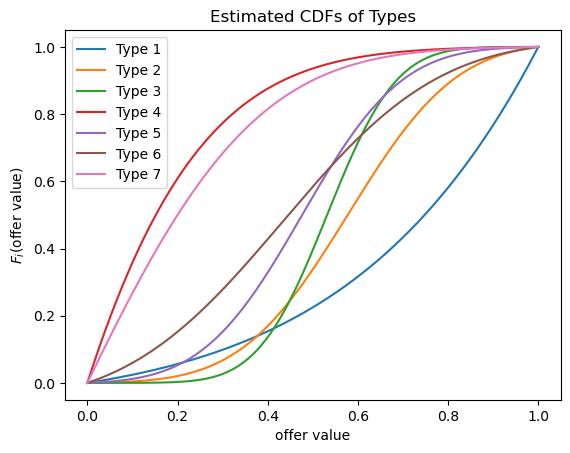

In [29]:
point_grid = [i for i in range(0, 1; length = 10001)]
for select_type in 1:K
    plot(point_grid, [cdf(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end

title("Estimated CDFs of Types")
xlabel("offer value")
ylabel("\$F_i\$(offer value\$)\$")
legend();

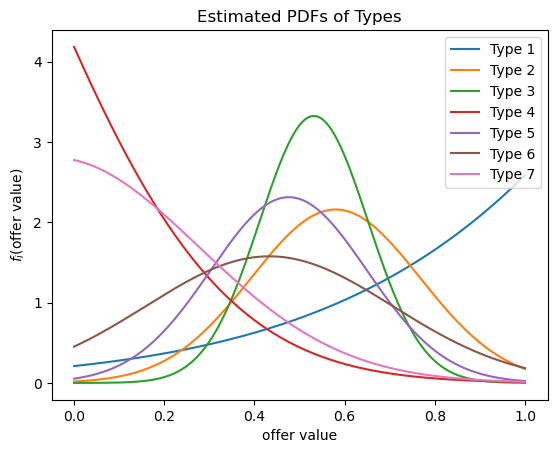

In [30]:
for select_type in 1:K
    plot(point_grid, [pdf(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end
title("Estimated PDFs of Types")
xlabel("offer value")
ylabel("\$f_i\$(offer value\$)\$")
legend();

In [31]:
for select_type in 1:K
    println("Type $(select_type):")
    println("  est. mean:   ", mean(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1)))
    println("  est. stddev: ", std(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1)))
    println()
end

Type 1:
  est. mean:   0.6863522246148488
  est. stddev: 0.24835763319917734

Type 2:
  est. mean:   0.5746378645731532
  est. stddev: 0.1791254777728839

Type 3:
  est. mean:   0.5317066174454328
  est. stddev: 0.11994810044940406

Type 4:
  est. mean:   0.19655724262450414
  est. stddev: 0.16837691576388095

Type 5:
  est. mean:   0.4769694641251955
  est. stddev: 0.16989264193164832

Type 6:
  est. mean:   0.4529289928759509
  est. stddev: 0.22817062186954515

Type 7:
  est. mean:   0.23908524967854994
  est. stddev: 0.18290829941649808



In [32]:
function pi(t, α)
    return α[t] / sum(α[1:t])
end

function print_metrics(p_vec, v_rel, gamma, mkt_balance_ratio, placements, k, K, M, m_val)
    α = mkt_balance_ratio * gamma
    n_val = (m_val / mkt_balance_ratio) + 1
    
    μ = p_vec[1:K]
    σ = p_vec[K+1:2K]
    ρ_vec = p_vec[2K+1:3K]
    ρ = ρ_vec / sum(ρ_vec)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]
    
    n = n_val * ρ

    ρ_q_it_true = placements / n_val
    
    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end

    objective_chisquare = 0.0
    objective_likelihood = 0.0
    objective_likelihood_simple = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    ρ_i_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        q_it[i, t] = prob
        ρ_i_q_it[i, t] = ρ[i] * prob
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    # TODO: div by zero and negative floating point in mean
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * ρ_i_q_it[i, t] / normalizer
        exp_placements[i, t] = expectation
        objective_chisquare += (placements[i, t] - expectation) ^ 2 / expectation
        objective_likelihood_simple += placements[i, t] * log(ρ_i_q_it[i, t] / normalizer)
    end 

    println("chi-square objective value (successful placements) = ", objective_chisquare)

    likelihood_probability_vector = zeros(k * K)
    total_placements_vector = zeros(k * K)
    vector_counter = 1
    for i in 1:K
        for t in 1:k
            likelihood_probability_vector[vector_counter] = (ρ_i_q_it[i, t] / normalizer)
            total_placements_vector[vector_counter] = placements[i, t]
            vector_counter += 1
        end
    end
    println("probability vector sum = ", sum(likelihood_probability_vector))
    println("actual likelihood = ", loglikelihood(Multinomial(M, likelihood_probability_vector), total_placements_vector))
    println("value proportional to fitness likelihood = ", -objective_likelihood_simple)
    println()
    println("estimated total departments = ", n_val)
    println("successful departments in sample = ", M)
    println("estimated unsuccessful departments = ", n_val - M)
    println("estimated probability of department success: ", M / n_val)
    println("predicted probability of department success: ", normalizer)
    println("estimated probability of department failure: ", 1 - (M / n_val))
    println()
    println("estimated beliefs of proportion of departments in each tier:")
    for i in 1:K
        println("ρ_", i, " = ", ρ[i])
    end
    println()
    println("estimated departments in each tier:")
    for i in 1:K
        println("n_", i, " = ", n[i])
        println("  Successful (data): ", sum(placements[i, :]))
        println("  Est. unsuccessful: ", n[i] - sum(placements[i, :]))
        println("  Estimated success probability: ", sum(placements[i, :]) / n[i])
        println("  Estimated failure probability: ", 1 - (sum(placements[i, :]) / n[i]))
    end
    println()

    println("rational expectations condition:")
    total_sum = sum(placements) + sum([n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    for i in 1:K
        predicted_ρ_output = (sum(placements[i, :]) + n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k]))) / total_sum
        println("tier ", i)
        println("  Input rho: ", ρ[i])
        println("  Predicted rho: ", predicted_ρ_output)
        println("  Predicted - Input: ", predicted_ρ_output - ρ[i])
        println("  Squared Difference: ", (predicted_ρ_output - ρ[i])^2)
    end
    println()

    println("expected number of tier i departments making offers to tier t graduates:")
    tier_selection_matrix = zeros(K, k)
    for i in 1:K, t in 1:k 
        tier_selection_matrix[i, t] = n_val * ρ[i] * sum([((cdf(normals[i], x_vec[s]) - cdf(normals[i], x_vec[s+1])) * α[t] / sum(α[1:s])) for s in t:k])
    end
    display(tier_selection_matrix)
    println()

    println("expected number of unsuccessful departments given above matrix:")
    display(tier_selection_matrix - placements)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Hiring probabilities (q_i^t):")
    display(q_it)
    println()

    println("Probabilities of failing (1 - sum_t q_i^t):")
    display(round_1_failure)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (sum(n) - 1))
        println("  Successful (data): ", sum(placements[:, i]))
        println("  Est. unsuccessful: ", (α[i] * (sum(n) - 1)) - sum(placements[:, i]))
        println("  Exp. unsuccessful: ", (α[i] * (sum(n) - 1)) - sum(exp_placements[:, i]))
        println("  Est. success probability: ", sum(placements[:, i]) / (α[i] * (sum(n) - 1)))
        println("  Est. failure probability: ", 1 - (sum(placements[:, i]) / (α[i] * (sum(n) - 1))))
        println("  Exp. success probability: ", sum(exp_placements[:, i]) / (α[i] * (sum(n) - 1)))
        println("  Exp. failure probability: ", 1 - (sum(exp_placements[:, i]) / (α[i] * (sum(n) - 1))))
    end
    println()
    println("estimated total graduates: ", m_val)
    println("successful graduates in sample: ", M)
    println("estimated unsuccessful graduates: ", m_val - M)
    println()
    println("estimated placement rates:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value, successful placements")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective_chisquare))
    println()
    println("estimated successful departments in each tier:")
    display([sum(exp_placements[i, :]) for i in 1:K])
    println()
    println("actual successful departments in each tier:")
    display([sum(placements[i, :]) for i in 1:K])
    println()
    println("estimated successful graduates in each tier:")
    display([sum(exp_placements[:, t]) for t in 1:k])
    println()
    println("actual successful graduates in each tier:")
    display([sum(placements[:, t]) for t in 1:k])
    println()
    println("μ parameter values")
    println(μ)
    println()
    println("σ parameter values")
    println(σ)
    println()

    means = zeros(K)
    stddevs = zeros(K)
    for i in 1:K
        means[i] = mean(normals[i])
        stddevs[i] = std(normals[i])
    end

    slides_table = zeros(3, K)
    slides_table[1, :] = round.(ρ[:]; digits = 3)
    slides_table[2, :] = round.(means[:], digits = 3)
    slides_table[3, :] = round.(stddevs[:], digits = 3)
    var_names = [raw"$v_i$", raw"$\gamma_i$", raw"$\rho_i$", raw"$mean(F_i)$", raw"$std(F_i)$"]
    values = ones(k)
    v_base = 1
    for i in 1:k
        println("v", i, ": ", v_base)
        if i != k
            v_base = v_rel[i] * v_base
            values[i+1] = round(v_base; digits = 3)
        end
    end

    base_mat = Matrix(undef, 2, K)
    base_mat[1, 1:k] = values[:]
    base_mat[2, 1:k] = round.(gamma[:], digits = 3)
    base_mat[:, k+1:K] .= ""
    
    full_slides_table = hcat(var_names, vcat(base_mat, slides_table))
    
    successful_department_counts = [sum(placements[i, :]) for i in 1:K]
    successful_department_proportions = successful_department_counts / sum(successful_department_counts)
    fraction_res = hcat(1:K, ρ, successful_department_proportions)
    return x_vec, pretty_table(fraction_res; header = ["Tier", "Estimated ρ beliefs", "Proportion of successful depts among tiers"]), pretty_table(full_slides_table; header = vcat([""], ["Tier $i" for i in 1:K]), backend=Val(:latex))
end

print_metrics (generic function with 1 method)

In [33]:
cutoffs, table, slides_table = print_metrics(sol_2, estimated_v_rel, estimated_γ, estimated_τ, res.placements, k, K, M, estimated_m_val)
table

chi-square objective value (successful placements) = 43.94897614893253
probability vector sum = 1.0
actual likelihood = -120.14509666083904
value proportional to fitness likelihood = 32956.66542832123

estimated total departments = 25890.130592556892
successful departments in sample = 10995
estimated unsuccessful departments = 14895.130592556892
estimated probability of department success: 0.4246792020107049
predicted probability of department success: 0.42467920201070514
estimated probability of department failure: 0.5753207979892951

estimated beliefs of proportion of departments in each tier:
ρ_1 = 0.03043176500888117
ρ_2 = 0.0750638268170348
ρ_3 = 0.12721222849341524
ρ_4 = 0.10659225528621064
ρ_5 = 0.09381330215891111
ρ_6 = 0.08608889792228343
ρ_7 = 0.4807977243132636

estimated departments in each tier:
n_1 = 787.8823702419368
  Successful (data): 536
  Est. unsuccessful: 251.88237024193677
  Estimated success probability: 0.6803045990677635
  Estimated failure probability: 0.3196

7×4 Matrix{Float64}:
  534.213   150.106    77.6355    25.9283
  891.208   642.538   325.146     84.52
 1136.87   1293.83    717.445    145.398
  613.412   793.119   913.559    439.598
  803.604   838.946   598.201    188.088
  811.202   688.27    530.938    198.443
 2890.06   3641.81   4034.58    1881.47


expected number of unsuccessful departments given above matrix:


7×4 Matrix{Float64}:
  151.213    66.1058    22.6355   11.9283
  449.208   226.538    125.146     2.52
  714.87    567.829    119.445    42.398
  525.412   569.119    620.559   199.598
  510.604   402.946    192.201    52.088
  459.202   368.27     201.938    81.4428
 2355.06   2609.81    2333.58    913.471


pi_1 = 1.0
pi_2 = 0.5770757263057628
pi_3 = 0.4156771799628942
pi_4 = 0.17483159828536435

Tier selection probabilities for making offers:


4×4 Matrix{Float64}:
 1.0       0.0       0.0       0.0
 0.422924  0.577076  0.0       0.0
 0.247124  0.337199  0.415677  0.0
 0.203919  0.278246  0.343004  0.174832


Hiring probabilities (q_i^t):


7×4 Matrix{Float64}:
 0.48395    0.114727   0.0605522  0.0215639
 0.230971   0.202818   0.119521   0.0336132
 0.123708   0.233013   0.167244   0.0371425
 0.0343576  0.0695008  0.125914   0.0764802
 0.120678   0.181094   0.163915   0.0574234
 0.15705    0.149003   0.137866   0.0577556
 0.0433349  0.0821231  0.136433   0.0784142


Probabilities of failing (1 - sum_t q_i^t):


7-element Vector{Float64}:
 0.31920700717097095
 0.41307701101810035
 0.4388928117776276
 0.6937476145172978
 0.47688950970239596
 0.49832631978179287
 0.6596953547589


x_0 = 1.0
x_1 = 0.7210435918317265
x_2 = 0.5523327689989204
x_3 = 0.4517303197784762
x_4 = 0.0

F(x_0) = 1.0
F(x_1) = 0.9311727646366591
F(x_2) = 0.7832547879084057
F(x_3) = 0.6547006828076294

α_1 = 0.10290032685631777
  Est. graduates: 2664.0000000000005
  Successful (data): 2515
  Est. unsuccessful: 149.00000000000045
  Exp. unsuccessful: 149.0000000000009
  Est. success probability: 0.944069069069069
  Est. failure probability: 0.055930930930931044
  Exp. success probability: 0.9440690690690687
  Exp. failure probability: 0.055930930930931266
α_2 = 0.14040641446047863
  Est. graduates: 3635.0000000000005
  Successful (data): 3238
  Est. unsuccessful: 397.00000000000045
  Exp. unsuccessful: 397.0000000000023
  Est. success probability: 0.8907840440165061
  Est. failure probability: 0.10921595598349387
  Exp. success probability: 0.8907840440165056
  Exp. failure probability: 0.10921595598349443
α_3 = 0.1730842209621471
  Est. graduates: 4481.0
  Successful (data): 3582
  Est. unsuc

7×4 Matrix{Float64}:
 381.296     90.3912    47.708   16.9898
 448.872    394.159    232.278   65.3243
 407.437    767.437    550.825  122.33
  94.8163   191.8      347.483  211.061
 293.108    439.847    398.123  139.472
 350.041    332.105    307.282  128.729
 539.429   1022.26    1698.3    976.093


actual placement rates:


7×4 Matrix{Int64}:
 383    84    55   14
 442   416   200   82
 422   726   598  103
  88   224   293  240
 293   436   406  136
 352   320   329  117
 535  1032  1701  968


difference between estimated and actual placement rates:


7×4 Matrix{Float64}:
  -1.70417     6.39119   -7.29202    2.9898
   6.87213   -21.8414    32.2783   -16.6757
 -14.5625     41.437    -47.1751    19.3303
   6.81633   -32.1995    54.4827   -28.9386
   0.108434    3.84724   -7.87699    3.47229
  -1.95914    12.1047   -21.7175    11.7288
   4.42893    -9.73916   -2.69934    8.09317


chi-square p-value, successful placements
0.00058666577662847

estimated successful departments in each tier:


7-element Vector{Float64}:
  536.3847968342369
 1140.6333436559512
 1848.0296468883666
  845.160852350595
 1270.5509740281384
 1118.1567917456277
 4236.083594497084


actual successful departments in each tier:


7-element Vector{Int64}:
  536
 1140
 1849
  845
 1271
 1118
 4236


estimated successful graduates in each tier:


4-element Vector{Float64}:
 2514.9999999999995
 3237.999999999998
 3582.000000000001
 1660.0000000000014


actual successful graduates in each tier:


4-element Vector{Int64}:
 2515
 3238
 3582
 1660


μ parameter values
[3.999999999936924, 0.5801376563268917, 0.5317276375909676, -0.5035195580929905, 0.47609846781973447, 0.432874048479548, -0.04468863005674484]

σ parameter values
[1.1805510559398393, 0.18720957145260902, 0.12000000000002144, 0.4095427682438633, 0.17318685942456305, 0.2738649712507511, 0.3205019552876221]

v1: 1
v2: 0.5122856729316855
v3: 0.27892247902388606
v4: 0.20483397061511488
┌──────┬─────────────────────┬────────────────────────────────────────────┐
│ Tier │ Estimated ρ beliefs │ Proportion of successful depts among tiers │
├──────┼─────────────────────┼────────────────────────────────────────────┤
│  1.0 │           0.0304318 │                                  0.0487494 │
│  2.0 │           0.0750638 │                                   0.103683 │
│  3.0 │            0.127212 │                                   0.168167 │
│  4.0 │            0.106592 │                                  0.0768531 │
│  5.0 │           0.0938133 │                                 

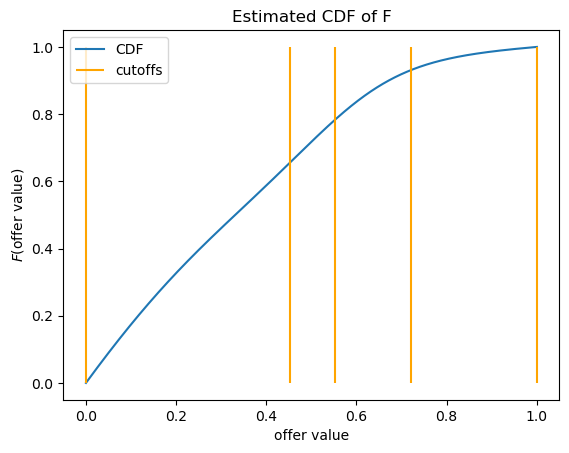

In [34]:
F_cdf_grid = zeros(10001)
sol_ρ_vec = sol_2[2K+1:3K]
sol_ρ = sol_ρ_vec / sum(sol_ρ_vec)
for i in 1:10001
    for select_type in 1:K
        F_cdf_grid[i] += sol_ρ[select_type] * cdf(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1), point_grid[i]) 
    end
end
    
plot(point_grid, F_cdf_grid, label = "CDF")
vlines(cutoffs, minimum(F_cdf_grid), maximum(F_cdf_grid), color = "orange", label = "cutoffs")

title("Estimated CDF of F")
xlabel("offer value")
ylabel("\$F\$(offer value\$)\$")
legend();

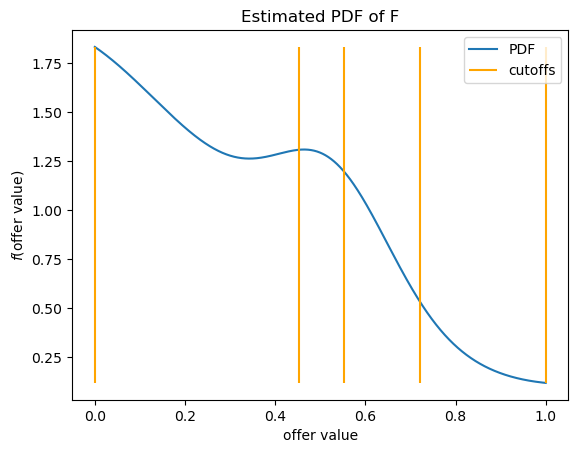

In [35]:
F_pdf_grid = zeros(10001)
for i in 1:10001
    for select_type in 1:K
        F_pdf_grid[i] += sol_ρ[select_type] * pdf(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1), point_grid[i]) 
    end
end

plot(point_grid, F_pdf_grid, label = "PDF")
vlines(cutoffs, minimum(F_pdf_grid), maximum(F_pdf_grid), color = "orange", label = "cutoffs")

title("Estimated PDF of F")
xlabel("offer value")
ylabel("\$f\$(offer value\$)\$")
legend();

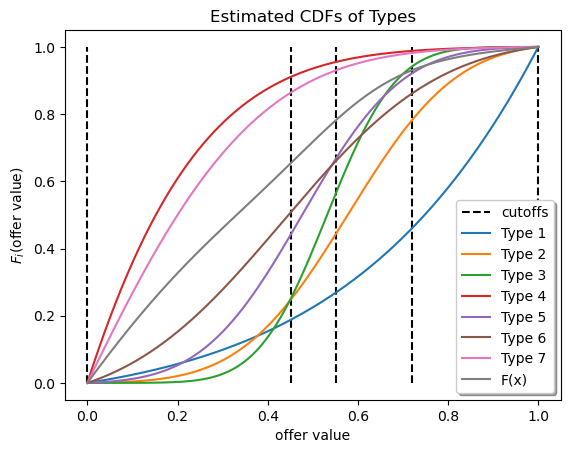

In [36]:
vlines(cutoffs, minimum(F_cdf_grid), maximum(F_cdf_grid), color = "black", linestyles = "dashed", label = "cutoffs")

for select_type in 1:K
    plot(point_grid, [cdf(truncated(Normal(sol_2[select_type], sol_2[select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end

plot(point_grid, F_cdf_grid, label = "F(x)")

title("Estimated CDFs of Types")
xlabel("offer value")
ylabel("\$F_i\$(offer value\$)\$")
legend(shadow = true)
savefig("cdfs.png");

In [37]:
round(estimated_τ; digits = 3)

0.505

## 7. Save results

In [38]:
save("estimated_parameters_truncated_normal.jld", "sol_2", sol_2, "estimated_v_rel", estimated_v_rel, "estimated_γ", estimated_γ, "estimated_τ", estimated_τ, "estimated_α", estimated_α, "k", k, "K", K, "estimated_n_val", estimated_n_val, "m_t_values", m_t_values[1:k]) 